### Imports

This code was originally written by Jack Gourdeau, and modified for use in this project (Dartmouth College).
Physicochemical properties table from Kogay et al. 2019 Table S7 and originally in Kaundal et al. 2013.

Kogay, R., Neely, T. B., Birnbaum, D. P., Hankel, C. R., Shakya, M., & Zhaxybayeva, O. (2019). Machine-Learning Classification Suggests That Many Alphaproteobacterial Prophages May Instead Be Gene Transfer Agents. Genome Biology and Evolution, 11(10), 2941–2953. https://doi.org/10.1093/gbe/evz206

Kaundal, R., Sahu, S. S., Verma, R., & Weirick, T. (2013). Identification and characterization of plastid-type proteins from sequence-attributed features using machine learning. BMC Bioinformatics, 14(14), S7. https://doi.org/10.1186/1471-2105-14-S14-S7


In [1]:
# prevent depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import os

In [3]:
outputs = 'output_files/'
#output folder

tree = 'input_files/gene_hits_tree.fasta'
#Fasta file of grs sequences to pull identifiers

physico_props = '/global/cfs/cdirs/m342/lblum/hotsprings_metaG/metadata/Table_S7.csv'
#Table of physicochemical properties for amino acids

grsA_group = 'input_files/grsA_relatives.txt'
grsB_group = 'input_files/grsB_relatives.txt'
#text files with identifiers of closer relatives of grsA and grsB type proteins (100% bootstrap values)
#For the purposes of this code, the "grsB" group is just used to define anything "not grsA." 

### Dataframe Creation


In [4]:
with open(tree) as fasta_file:  
    identifiers = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID

In [5]:
Alist = []
Blist = []
#Sequence fasta file used for tree
with open(grsA_group) as infileA:     
    for line in infileA: 
        Alist.append(line.strip().replace(" ","_"))
with open(grsB_group) as infileB:     
    for line in infileB: 
        Blist.append(line.strip().replace(" ","_"))

# read in the physicochemical properties (supplemental table 7 from Kogay et. al)
properties = pd.read_csv(physico_props).dropna()
properties['index_position'] = properties.index

- Read in the sequences and collect properties to sum

In [6]:
# to get the properties of each Amino Acid
def get_properties(sequence):
    
    properties_agg = []
    for AA in sequence: 
        # each AA has its own set of properties
        indiv_prop = [0]*len(list(properties['Physicochemical property']))
        # print(indiv_prop)

        ones = list(properties[properties['Amino acids'].str.contains(str(AA))]['index_position'])
        for ind in ones:
            indiv_prop[ind] = 1
        
        properties_agg.append(indiv_prop)
        
        # sum up the individual amino acid characteristics 
        summed = list(np.sum(properties_agg, axis=0))
        
        string_sum = [str(int) for int in summed] 
        str_of_sums = ",". join(string_sum)
    
    return str_of_sums


In [7]:
# lists to store the data before creation of the df
my_seqs = []
my_names = []
groupA = []
groupB = []

# read in the sequences
for seq_record in SeqIO.parse(tree, "fasta"):
    my_seqs.append(str(seq_record.seq))
    my_names.append(seq_record.id)
    groupA.append(seq_record.id in Alist)
    groupB.append(seq_record.id in Blist)
# create the dataframe
data = {'id': my_names, 'sequence': my_seqs, 'groupA': groupA, 'groupB': groupB}
seq_df = pd.DataFrame(data)

In [8]:
# make a column that stores the properties
# Long step
seq_df["properties"] = seq_df.apply(lambda row: get_properties(row['sequence']), axis=1)

#print(seq_df.loc[0, 'properties'])

### SVC

In [9]:
col_list = []
for i in range(19):
    col_list.append('p'+str(i))  

props = seq_df['properties'].str.split(',', expand=True)

props.columns = col_list

In [10]:
#### grsA #######
# create a classifier (0 for non A, 1 for A)
seq_df['classA'] = np.where(seq_df['groupA'], 'A', "Non-A")
seq_df['classB'] = np.where(seq_df['groupB'], 'B', "Non-B")

#for creating the classifier we will just use the distinct grsA and grsB groups
class_df = pd.concat([seq_df[seq_df['groupA']==True],seq_df[seq_df['groupB']==True]])

#X is the properties
X = class_df['properties'].str.split(',', expand=True)
y = list(class_df['classA'])

### Implementing tests

In [11]:
print(X.shape)


(78, 19)


<AxesSubplot:>

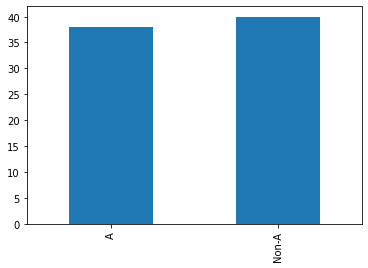

In [12]:
# check that we have balanced data
class_df['classA'].value_counts().sort_index().plot.bar()

### Split the data for cross validation 

In [13]:
# splitting the data into training and test set so we can do cross validation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=6, 
                                                    shuffle=True)

print(X_train.shape)
print(X_test.shape)

(62, 19)
(16, 19)


### Create the classifier

In [14]:
## Multinomial Naive Bayes Classifier
classifier = SVC()
classifier.fit(X_train, y_train)


SVC()

In [15]:
# try it on some new data
y_pred = classifier.predict(X_test)

### Create a confusion matrix

In [144]:
print("Confusion matrix \n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
cross_val = cross_val_score(classifier, X, y)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val.mean(), cross_val.std()))


Confusion matrix 

Predicted  A  Non-A
Actual             
A          8      0
Non-A      0      8
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000
0.96 accuracy with a standard deviation of 0.03


In [16]:
#Scale it up
y_pred = classifier.predict(props)

In [17]:
predictions = pd.merge(pd.DataFrame(y_pred), seq_df, left_index = True, right_index = True)

In [21]:
predictions = predictions.rename(columns = {0 : 'Predicted' , 'classA': 'training_groupA', 'classB': 'training_groupB' })

In [140]:
predictions.to_csv(os.path.join(outputs,'ml_grs_classification.csv'))

In [24]:
predictions.loc[:,['Predicted','id','sequence','',6,7]]

,Predicted,id,sequence,properties,training_groupA,training_groupB
0,A,WP_221287845.1,MLVRKPIRMLSGVTVVSVMTAPSRCPHGKCIFCPGGVDYNTPQSYY...,"140,91,76,64,165,46,55,107,80,21,233,22,28,44,...",Non-A,Non-B
1,A,WP_221267127.1,MLSGVTIVSVMTHPHRCPHGKCIFCPGGVEYGTPQSYYGNEPTLMR...,"145,93,77,68,155,50,65,102,79,23,224,24,28,42,...",Non-A,Non-B
2,A,WP_012717367.1,MQVIRKPTRMLSGVTIVSIMTHPHSCPHGKCVFCPGGVDVDTPQSY...,"147,97,82,65,163,47,62,99,78,23,229,25,23,48,2...",Non-A,Non-B
3,A,RLE61639.1,MKKVKKPVRSISGVVIVAAMTKPFPCPHGKCIYCPGGTDWRTPQSY...,"152,88,98,54,157,49,58,98,96,22,236,22,29,39,2...",Non-A,Non-B
4,A,HGQ25970.1,MRLGRKPSRILSGVTVVAVMTAPHPCPHGRCAYCPGGPDFGTPQSY...,"140,85,77,63,184,45,50,113,90,21,249,20,28,41,...",Non-A,Non-B
...,...,...,...,...,...,...
2148,Non-A,648118220,MKAVSEGFKVVLTAEGATASDTLGASVAGFISALPDSYIKPLIART...,"133,105,70,63,222,46,66,155,80,24,298,20,34,63...",Non-A,Non-B
2149,A,Ga0187840_100066261,KVFCPSVETDPVTGEAKVAQCGLRRIESALLKEYKREEVFIAHPDM...,"135,83,73,62,173,41,76,101,70,30,256,31,24,41,...",Non-A,Non-B
2150,A,Ga0187840_100010923,MKGKKIVLTADRSLMSNYRDNMLFGFVACMPVEKISKQIYYRVFCP...,"143,94,76,67,178,55,79,113,86,32,264,26,25,45,...",Non-A,Non-B
2151,Non-A,Ga0187840_100006024,MVQVVLTFDPSLGHMFHNFPLLSFLPCAPVRYVPPPVYRYLSKPDV...,"143,110,82,61,233,52,85,146,93,32,328,35,35,55...",Non-A,Non-B
